In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
from datasets import CustomCIFAR10 as CIFAR10_dataset

In [3]:
from consts import *

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(cifar10_mean, cifar10_std)
    ])
batch_size = 32

In [5]:
trainset= CIFAR10_dataset("../data/", transform=transform, train = True)
testset= CIFAR10_dataset("../data/", transform=transform, train = False)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=False)

In [7]:
torch.hub.set_dir('/mnt/DONNEES/hbrachemi/.cache/torch/hub/checkpoints/')

In [8]:
from victim_model import *

In [9]:
model_ft= VictimModel("vgg16",True,10)

In [10]:
from utils import *

In [11]:
hyperparametters = {}
hyperparametters["sigma"]=0.1
hyperparametters["lambda"]=1
hyperparametters["criterion"] = torch.nn.CrossEntropyLoss()
hyperparametters["sponge_optimizer"] = torch.optim.SGD(model_ft.model.parameters(),lr=0.01, momentum=0.9,weight_decay= 5e-4)
hyperparametters["num_sponge_epochs"] = 50
hyperparametters["sponge_criterion"] = "l0"
hyperparametters["num_epochs"] = 10
hyperparametters["criterion"] = torch.nn.CrossEntropyLoss()
hyperparametters["optimizer"] = torch.optim.Adam(model_ft.model.parameters(), lr=0.1)


In [12]:
from torch.utils.tensorboard import SummaryWriter

In [13]:
writer = SummaryWriter()

In [14]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [15]:
#a = model_ft.train({"train":trainloader,"val":testloader},hyperparametters,writer=writer)
PATH = "../weights_sponge_backdoor/clean/vgg16.pt"
model_ft.model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
a = model_ft.evaluate(testloader)

KeyboardInterrupt: 

In [20]:
np.mean(a["energy"]["ratio_cons"])

0.77949786

In [21]:
a["accuracy"]

0.9101

In [ ]:
np.mean(a["energy"]['worst_case_cons'])

In [16]:
p_ids = [random.randint(1,len(trainset)) for _ in range(int(0.05*len(trainset)))]

In [ ]:
stats = dict()

dataloaders= {"train":trainloader,"val":testloader}

a = model_ft.sponge_train(dataloaders,
                          p_ids,
                          hyperparametters,
                          writer)

100%|██████████| 10000/10000 [00:51<00:00, 193.39it/s]


In [ ]:
%debug

> /mnt/DONNEES/hbrachemi/Sponge_attacks/victim_model.py(208)sponge_train()
    206                 epoch_loss += loss.item()
    207 
--> 208               stats["sponge_loss_"+str(phase)][-1] /= len(dataloaders[phase])
    209               stats["epoch_loss_"+str(phase)][-1] /= len(dataloaders[phase])
    210 

ipdb> stats["sponge_loss_"+str(phase)][-1]
{'sponge_loss': 0.40101534128189087, 'sponge_stats': (0.40101534128189087, 18587637.0, 0.5508075915277004, 24143.97123146057)}
ipdb> stats["sponge_loss_"+str(phase)]
[0, {'sponge_loss': 0.40101534128189087, 'sponge_stats': (0.40101534128189087, 18587637.0, 0.5508075915277004, 24143.97123146057)}]


In [20]:
a = model_ft.evaluate(testloader)

100%|██████████| 10000/10000 [00:52<00:00, 189.55it/s]


In [29]:
for i, (inputs,labels) in enumerate testloader:
    

0.80188125

In [24]:
np.mean(a["energy"])

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

In [17]:
import random

In [ ]:
from consts import BENCHMARK
from utils import *

torch.backends.cudnn.benchmark = BENCHMARK

def data_sponge_loss(model, x, victim_leaf_nodes, args):
    sponge_stats = SpongeMeter(args)

    def register_stats_hook(model, input, output):
        sponge_stats.register_output_stats(output)

    hooks = register_hooks(victim_leaf_nodes, register_stats_hook)

    outputs = model(x)

    sponge_loss = fired_perc = fired = l2 = 0
    for i in range(len(sponge_stats.loss)):
        sponge_loss += sponge_stats.loss[i].to('cuda')
        fired += float(sponge_stats.fired[i])
        fired_perc += float(sponge_stats.fired_perc[i])
        l2 += float(sponge_stats.l2[i])
    remove_hooks(hooks)

    sponge_loss /= len(sponge_stats.loss)
    fired_perc /= len(sponge_stats.loss)

    return sponge_loss, outputs, (float(sponge_loss), fired, fired_perc, l2)


In [ ]:
from energy_estimation import check_sourceset_consumption

In [ ]:
def data_sponge_loss(model, x, victim_leaf_nodes, args):
    sponge_stats = SpongeMeter(args)

    def register_stats_hook(model, input, output):
        sponge_stats.register_output_stats(output)

    hooks = register_hooks(victim_leaf_nodes, register_stats_hook)

    outputs = model(x)

    sponge_loss = fired_perc = fired = l2 = 0
    for i in range(len(sponge_stats.loss)):
        sponge_loss += sponge_stats.loss[i].to('cuda')
        fired += float(sponge_stats.fired[i])
        fired_perc += float(sponge_stats.fired_perc[i])
        l2 += float(sponge_stats.l2[i])
    remove_hooks(hooks)

    sponge_loss /= len(sponge_stats.loss)
    fired_perc /= len(sponge_stats.loss)

    return sponge_loss, outputs, (float(sponge_loss), fired, fired_perc, l2)

def sponge_step_loss(model, inputs, victim_leaf_nodes, args):
    sponge_loss, _, sponge_stats = data_sponge_loss(model, inputs, victim_leaf_nodes, args)
    sponge_stats = dict(sponge_loss=float(sponge_loss), sponge_stats=sponge_stats)
    return sponge_loss, sponge_stats

In [ ]:
model = model_ft.model

In [16]:
import matplotlib.pyplot as plt

In [17]:
import os

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224)),
  ])
    
batch_size = 4


In [ ]:
trainset= CIFAR10_dataset("../data/cifar-10-batches-py/", transform=transform, phase = "train")
testset= CIFAR10_dataset("../data/cifar-10-batches-py/", transform=transform, phase = "test")
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4, shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=False,num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


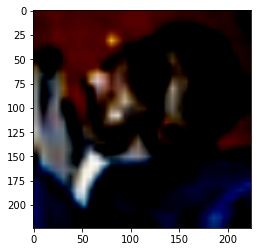